In [70]:
%reset -f
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from joblib import dump, load

np.set_printoptions(suppress=True) # don't show standard notation

In [73]:
path = "../data/UCI HAR Dataset/"

# load target classes
Ytr = np.loadtxt(path + "train/y_train.txt")
Yte = np.loadtxt(path + "test/y_test.txt")

In [74]:
# load raw signal data
Xtr_totAcc = np.loadtxt(path + "train/Inertial Signals/total_acc_x_train.txt") # (7352, 128)
Ytr_totAcc = np.loadtxt(path + "train/Inertial Signals/total_acc_y_train.txt")
Ztr_totAcc = np.loadtxt(path + "train/Inertial Signals/total_acc_z_train.txt")

Xtr_bodAcc = np.loadtxt(path + "train/Inertial Signals/body_acc_x_train.txt") # (7352, 128)
Ytr_bodAcc = np.loadtxt(path + "train/Inertial Signals/body_acc_y_train.txt")
Ztr_bodAcc = np.loadtxt(path + "train/Inertial Signals/body_acc_z_train.txt")

Xtr_gyro = np.loadtxt(path + "train/Inertial Signals/body_gyro_x_train.txt") # (7352, 128)
Ytr_gyro = np.loadtxt(path + "train/Inertial Signals/body_gyro_y_train.txt")
Ztr_gyro = np.loadtxt(path + "train/Inertial Signals/body_gyro_z_train.txt")

[n,d] = Xtr_totAcc.shape
totAcc = np.array((Xtr_totAcc,Ytr_totAcc,Ztr_totAcc)).reshape(n,d,3)
bodAcc = np.array((Xtr_bodAcc,Ytr_bodAcc,Ztr_bodAcc)).reshape(n,d,3)
gyro = np.array((Xtr_gyro,Ytr_gyro,Ztr_gyro)).reshape(n,d,3)
Xtr_sig = np.concatenate((totAcc, bodAcc, gyro),axis=2) # (7352, 128, 9)

Xte_totAcc = np.loadtxt(path + "test/Inertial Signals/total_acc_x_test.txt") 
Yte_totAcc = np.loadtxt(path + "test/Inertial Signals/total_acc_y_test.txt")
Zte_totAcc = np.loadtxt(path + "test/Inertial Signals/total_acc_z_test.txt")

Xte_bodAcc = np.loadtxt(path + "test/Inertial Signals/body_acc_x_test.txt")
Yte_bodAcc = np.loadtxt(path + "test/Inertial Signals/body_acc_y_test.txt")
Zte_bodAcc = np.loadtxt(path + "test/Inertial Signals/body_acc_z_test.txt")

Xte_gyro = np.loadtxt(path + "test/Inertial Signals/body_gyro_x_test.txt") 
Yte_gyro = np.loadtxt(path + "test/Inertial Signals/body_gyro_y_test.txt")
Zte_gyro = np.loadtxt(path + "test/Inertial Signals/body_gyro_z_test.txt")

[n,d] = Xte_totAcc.shape
totAcc = np.array((Xte_totAcc,Yte_totAcc,Zte_totAcc)).reshape(n,d,3)
bodAcc = np.array((Xte_bodAcc,Yte_bodAcc,Zte_bodAcc)).reshape(n,d,3)
gyro = np.array((Xte_gyro,Yte_gyro,Zte_gyro)).reshape(n,d,3)
Xte_sig = np.concatenate((totAcc, bodAcc, gyro),axis=2) 

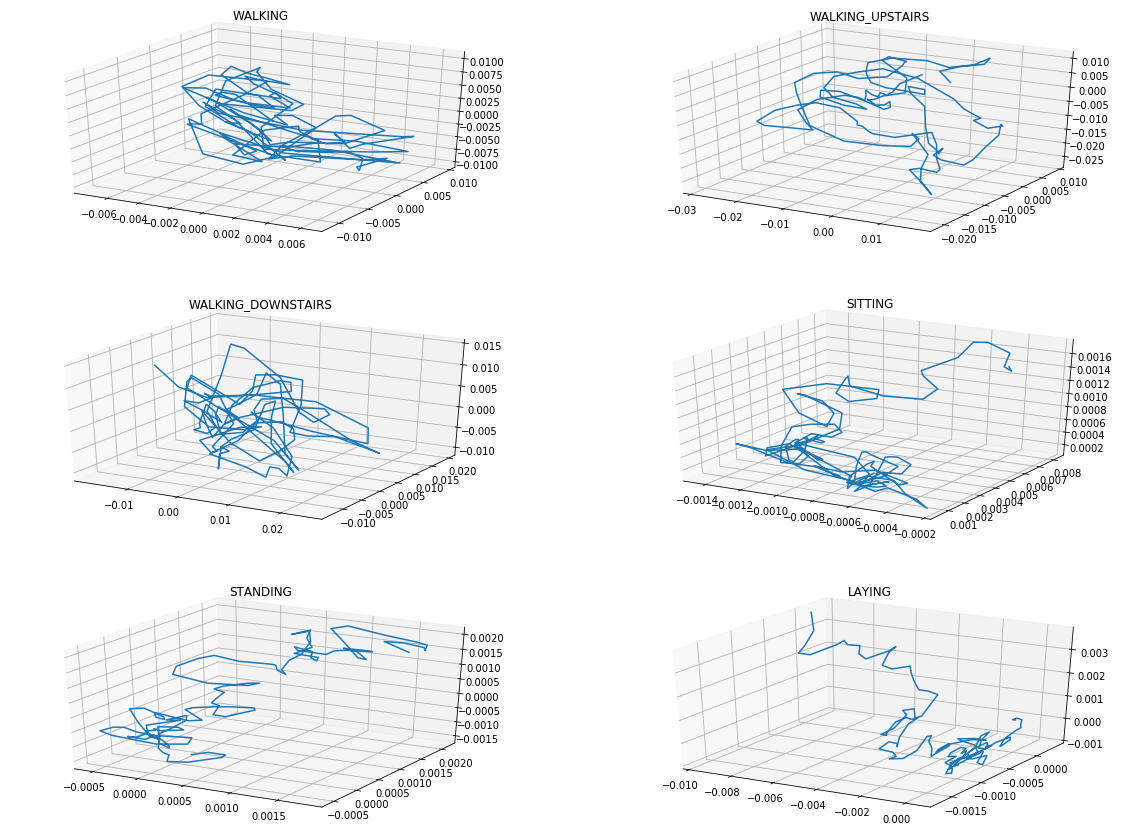

In [75]:
# see average across all trials and volunteers for activities
classes = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure(figsize=([20,15]))
data = list()
for cls in range(6):
    cls=cls+1
    x=bodAcc_avgX = np.mean(Xtr_bodAcc[Ytr==cls],axis=0)
    y=bodAcc_avgY = np.mean(Ytr_bodAcc[Ytr==cls],axis=0)
    z=bodAcc_avgZ = np.mean(Ztr_bodAcc[Ytr==cls],axis=0)

    
    ax=fig.add_subplot(3,2,cls, projection='3d')
    ax.plot(x,y,z)
    ax.set_title(classes[cls-1])
plt.show()

I took the average signals over all participants/trials per activity to visualize the general movement for each activity.  

The walking movements are recorded over all directions, which seems reasonable since walking generates quite large movements. I had expected walking upstairs and downstairs to be more similar to each other, but walking downstairs look more similar to walking -- perhaps people tend to conserve more energy going upstairs by steadying their movements more? 

The paper/readme didn't detail how the volunteers carried out the activities, so I assume all participants carried out the movement in the most controlled manner as possible -- which is why I'm surprised to see that laying (a very static activity) generates so much signals that it looks similiar to sitting (though the signal scale is different).  

I wonder if the classifier will have a difficult time differentiating between some of the classes (eg sitting/standing).

In [67]:
Xtr_sig.shape

(7352, 128, 9)

In [ ]:
# TODO: work with raw signals

#### Start working with extracted features first

In [29]:
XTR = np.loadtxt(path + "train/X_train.txt") # 7352, 561
XTE = np.loadtxt(path + "test/X_test.txt")

In [30]:
subjects = np.loadtxt(path + 'train/subject_train.txt')
len(subjects[subjects==1])

347

In [31]:
#np.unique(subjects)
#np.unique(np.loadtxt(path + 'test/subject_test.txt'))

In [33]:
# features are already normalized and bounded btwn [-1 1]
Xtr = XTR
Xte = XTE

#### can load 'grid_srch_clf.pkl' to skip long runtime with grid search or write new model based on best parameters found

Best parameters set found on development set:
{'C': 0.25, 'gamma': 0.011048543456039806}

Mean CV score of best estimator:
0.9085963003264418

In [ ]:
# build basic estimator
### default kernel: rbf
estimator = SVC(tol=1e-4)
print(estimator.get_params().keys()) # see how C and gamma are specified in list of available estimator parameters


# search range via: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf 
# page 5
Cs = np.logspace(-5,-2,base=2,num=5)
gammas = np.logspace(-15,2,base=2,num=5)

# set parameters
parameters = {'C':Cs, 'gamma':gammas}

# CV, 4 folds
k=4
grid_srch_clf = GridSearchCV(estimator, parameters, cv=k)

# save the model to disk (for rerun)
# dump(grid_srch_clf, 'grid_srch_clf.pkl') # this is a fitted model

# Fit model
grid_srch_clf.fit(Xtr, Ytr)

print("Best parameters set found on development set:")
print(grid_srch_clf.best_params_)
print()

print("Mean CV score of best estimator:")
print(grid_srch_clf.best_score_)
print()

In [35]:
grid_srch_clf = load('grid_srch_clf.pkl') # load model from disk to skip cell above

In [36]:
ypred = grid_srch_clf.predict(Xte)

accuracy = lambda true, pred: np.sum(pred==true)/len(true)
accuracy(Yte, ypred)

0.9423142178486597

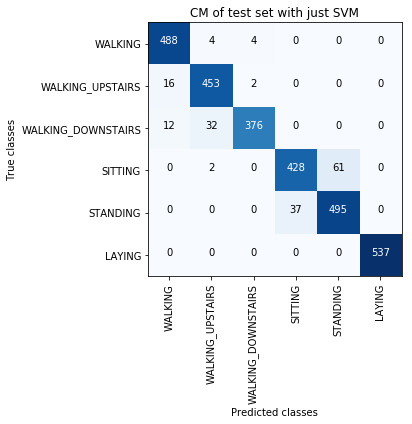

In [57]:
# confusion matrix of test set with just SVM
cm = confusion_matrix(Yte,ypred)

import importlib
import plotcm
#importlib.reload(plotcm) # reload only accepts modules -- I was editing plotcm.py -- IGNORE

title = 'CM of test set with just SVM'
xlabel = 'Predicted classes'
ylabel = 'True classes'
plotcm.plot_confusion_matrix(cm,title,xlabel,ylabel)

SVM classifier perfectly classifies LAYING (like the paper), but has trouble between SITTING/STANDING the most, and between WALKING/WALKING_UPSTAIRS/WALKING_DOWNSTAIRS. This is what the visualization suggested by the similar signal patterns generated by the activities.

In [59]:
## Combine SVM with HMM:
## use trained output classes of SVM classifier as observed
## and actual classes as hidden states

obs = grid_srch_clf.predict(Xtr)
accuracy(Ytr, obs) # check SVM training accuracy

0.9653155603917302

In [61]:
hidden = Ytr;

# make transition matrix 
n = len(np.unique(obs))
t = np.zeros((n,n))
for i in range(len(obs)-1):
    x,y = int(obs[i])-1, int(obs[i+1])-1 # minus 1 for zero index
    t[x,y] = t[x,y]+1

trans = t / np.sum(t,axis=1)
trans_smoothed = (t+1) / (np.sum(t,axis=1)+6) # laplace smoothing
row_sums = trans_smoothed.sum(axis=1)
trans_smoothed = trans_smoothed / row_sums[:, np.newaxis]

# Compute confusion matrix to make emission matrix
CM = confusion_matrix(hidden,obs)

emis = CM.T / np.sum(CM.T, axis=1)
emis_smoothed = (CM.T+1) / (np.sum(CM.T,axis=1)+6) # laplace smoothing

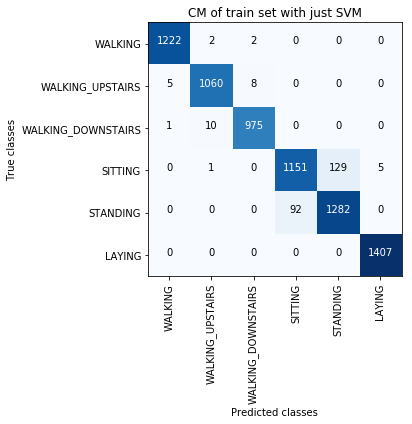

In [62]:
# confusion matrix of train set with just SVM 

title = 'CM of train set with just SVM'
xlabel = 'Predicted classes'
ylabel = 'True classes'
plotcm.plot_confusion_matrix(CM,title,xlabel,ylabel)

In [63]:
# via https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.MultinomialHMM 
from hmmlearn import hmm
model = hmm.MultinomialHMM(n_components=n,tol=1e-7,params='ste')

# ypred are predictions using Test data from SVM
ypred = ypred.reshape(len(ypred),1)
ypred = np.array(ypred-1,dtype=np.int8) # minus 1 for zero index

N = len(ypred)
classes = np.unique(ypred)
freq = lambda x: np.sum(ypred==x)/N
f = np.array(list(map(freq,classes))) # get frequencies for starting probabilities

model.startprob_ = f
model.transmat_ = trans_smoothed
model.emissionprob_ = emis_smoothed

logprob, Y = (model.decode(ypred)) # decode to find most likely sequence
print(accuracy_score(Yte,(Y+1).T))


0.9555480149304377


Hybrid SVM/HMM model improves the SVM results by ~2%, from 0.94 to 0.96. Not a spectacular improvement, and this is still something I'm studying at the moment.

## References
[1] Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013. 